## Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect vehicles on road.
* Output visual display of the detected cars.

---
## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import zipfile


from skimage.feature import hog
from skimage import data, exposure
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for (x1,y1),(x2,y2) in bboxes:
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    return draw_img # Change this line to return image copy with boxes



In [3]:
def color_hist(image, nbins=32, bins_range=(0, 256)):
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 1.0))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 1.0))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 1.0))
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [4]:
if not os.path.isfile('data' + os.sep + 'vehicles' + os.sep + 'GTI_MiddleClose' + os.sep + 'image0003.png'):
    zip_ref = zipfile.ZipFile('data' + os.sep + 'vehicles.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()
if not os.path.isfile('data' + os.sep + 'non-vehicles' + os.sep + 'GTI' + os.sep + 'image1.png'):
    zip_ref = zipfile.ZipFile('data' + os.sep + 'non-vehicles.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()

In [5]:
image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0003.png')
_, _, _, _, hist_features = color_hist(image, nbins=32, bins_range=(0, 256))
#print ('image', image)
print ('hist_features', hist_features.shape, hist_features)

hist_features (96,) [  0   0   0  23 549 600 444 434 262 217 175 171 154 155 124 112 106 114
 100  91 115  79  27  21  19   2   0   0   2   0   0   0   0   0   0   0
   4 377 804 414 335 400 293 194 186 147 112 110 100  97 114 125 141  61
  29  26  22   3   0   0   2   0   0   0   0   0   0   0  18 326 522 577
 402 370 374 253 232 167 126 100 135 147 126  59  77  43  32   5   2   1
   0   1   1   0   0   0]


In [6]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features


In [7]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [8]:
image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0003.png')
hog_features = get_hog_features(image, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)
print ('hog_features', hog_features)   

hog_features 0.18712957380649947


In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
#    for file in imgs:
    for image in imgs:
        # Read in each one by one
        if isinstance(image, str):
            image = mpimg.imread(image)
        _, _, _, _, hist_features = color_hist(image)
        hog_features = []
        hog_features.extend(hist_features.tolist())

        for colorspace in ['RGB','HSV','LUV','HLS','YUV', 'YCrCb']:
            feature_image = np.copy(image)
            if colorspace == 'HSV':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2HSV)
            elif colorspace == 'LUV':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2LUV)
            elif colorspace == 'HLS':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2HLS)
            elif colorspace == 'YUV':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2YUV)
            elif colorspace == 'YCrCb':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2YCrCb)
            
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))

        hog_features = np.ravel(hog_features)        

        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



In [10]:
features = extract_features(['./data/vehicles/GTI_MiddleClose/image0003.png'])
print ('features', features)

features [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.30000000e+01,
       5.49000000e+02, 6.00000000e+02, 4.44000000e+02, 4.34000000e+02,
       2.62000000e+02, 2.17000000e+02, 1.75000000e+02, 1.71000000e+02,
       1.54000000e+02, 1.55000000e+02, 1.24000000e+02, 1.12000000e+02,
       1.06000000e+02, 1.14000000e+02, 1.00000000e+02, 9.10000000e+01,
       1.15000000e+02, 7.90000000e+01, 2.70000000e+01, 2.10000000e+01,
       1.90000000e+01, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.00000000e+00, 3.77000000e+02, 8.04000000e+02, 4.14000000e+02,
       3.35000000e+02, 4.00000000e+02, 2.93000000e+02, 1.94000000e+02,
       1.86000000e+02, 1.47000000e+02, 1.12000000e+02, 1.10000000e+02,
       1.00000000e+02, 9.70000000e+01, 1.14000000e+02, 1.25000000e+02,
       1.41000000e+02, 6.10000000e+01, 2.90000000e+01, 2.60000000e+

In [11]:
def pipeline(img):
    return img

In [12]:
def process_image(img):
    img_und = cv2.undistort(img, mtx, dist, None, mtx)
    bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
    img_box = draw_boxes(img_und, bboxes)
    return img_box

In [13]:
#img = mpimg.imread('test_images/test1.jpg')

#rh, gh, bh, bincen, feature_vec = color_hist(img, nbins=32, bins_range=(0, 256))
#fig = plt.figure(figsize=(12,3))
#plt.subplot(131)
#plt.bar(bincen, rh[0])
#plt.xlim(0, 256)
#plt.title('R Histogram')
#plt.subplot(132)
#plt.bar(bincen, gh[0])
#plt.xlim(0, 256)
#plt.title('G Histogram')
#plt.subplot(133)
#plt.bar(bincen, bh[0])
#plt.xlim(0, 256)
#plt.title('B Histogram')
#fig.tight_layout()


In [14]:
#image = mpimg.imread('test_images/test1.jpg')
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
#features, hog_image = get_hog_features(gray, orient= 9, pix_per_cell= 8, cell_per_block= 2, vis=True, feature_vec=False)


# Plot the examples
#fig = plt.figure()
#plt.subplot(121)
#plt.imshow(image, cmap='gray')
#plt.title('Example Car Image')
#plt.subplot(122)
#plt.imshow(hog_image, cmap='gray')
#plt.title('HOG Visualization')


In [15]:
def get_dataset(directory):
    car_filelist = []
    notcar_filelist = []
    
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if name.endswith('.png'):
#                print (path, subdirs, name)
                if (os.sep + 'vehicles' + os.sep ) in path:
                    car_filelist.append(path + os.sep + name)
                if (os.sep + 'non-vehicles' + os.sep ) in path:
                    notcar_filelist.append(path + os.sep + name)

    return car_filelist, notcar_filelist


In [16]:
car_filelist, notcar_filelist = get_dataset('./data')

In [17]:
#print ('car', len(car_filelist), car_filelist)

In [18]:
#print ('car', len(notcar_filelist), notcar_filelist)

In [19]:
#print ('car')
#for i  in range(len(car_filelist)):
#    car_file =  car_filelist[i]
#    image = mpimg.imread(car_file)
#    print (car_file, image.shape)

In [20]:
#for i  in range(len(car_filelist)):
#    car_file =  car_filelist[i]
#    image = mpimg.imread(car_file)
#    if i % 1090 == 34:
#        fig = plt.figure()
#        plt.imshow(image)

In [21]:
#print ('notcar')
#for i in range(len(notcar_filelist)):
#    notcar_file =  notcar_filelist[i]
#    image = mpimg.imread(notcar_file)
#    print (notcar_file, image.shape)

In [22]:
#for i  in range(len(notcar_filelist)):
#    notcar_file =  notcar_filelist[i]
#    image = mpimg.imread(notcar_file)
#    if i % 1000 == 34:
#        fig = plt.figure()
#        plt.imshow(image)

In [23]:
X, y, mean, scale = None, None, None, None

X_train, X_test, y_train, y_test = None,  None,  None,  None

if os.path.isfile('dataset.npz'):
    print('dataset.npz exists')
    X_scaler = preprocessing.StandardScaler()
    dataset = np.load('dataset.npz')
    X, y, X_scaler.mean_ , X_scaler.scale_  = dataset['X'],  dataset['y'], dataset['mean'], dataset['scale']
else:
    print('dataset.npz new')
    car_features    = extract_features(car_filelist)
    notcar_features = extract_features(notcar_filelist)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y_car = np.ones((len(car_filelist)))
    y_notcar = np.zeros((len(notcar_filelist)))
    y = np.hstack((y_car, y_notcar)).astype(np.int)
    X_scaler = preprocessing.StandardScaler().fit(X)
    X = X_scaler.transform(X)
    np.savez_compressed('dataset.npz', X = X, y = y, mean = X_scaler.mean_, scale = X_scaler.scale_)


dataset.npz new


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=452553)
print ('X_train.shape', X_train.shape)
print ('y_train.shape', y_train.shape)
print ('X_test.shape', X_test.shape)
print ('y_test.shape', y_test.shape)


X_train.shape (14208, 114)
y_train.shape (14208,)
X_test.shape (3552, 114)
y_test.shape (3552,)


In [25]:
model = None
if not os.path.isfile('model.pkl'):
    C_range = [0.235]
    gamma_range = [0.03]
    #C_range = [0.230, 0.235, 0.240, 0.245]
    #gamma_range = [0.020, 0.025, 0.030, 0.035]
    for C in C_range:
        for gamma in gamma_range:
            print ('C', C, 'gamma', gamma)
            model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            model.fit(X_train, y_train)
            joblib.dump(model, 'model.pkl') 
        print ('training end')
else:
    model = joblib.load('model.pkl') 


print ('score train', model.score(X_train, y_train))
y_train_pred = model.predict(X_train)
print ('confusion matrix train', confusion_matrix(y_train, y_train_pred))
print ('score test', model.score(X_test, y_test))
y_test_pred = model.predict(X_test)
print ('confusion matrix test', confusion_matrix(y_test, y_test_pred))



C 0.235 gamma 0.03
training end
score train 0.9748029279279279
confusion matrix train [[7070  116]
 [ 242 6780]]
score test 0.9676238738738738
confusion matrix test [[1745   37]
 [  78 1692]]


In [26]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image_features [[ 0.06979675 -0.54036279 -0.74297657 -0.93768982 -0.96738451 -0.97517433
  -0.92423804 -0.91422728 -0.90406627 -0.80360645 -0.72201239 -0.70308259
  -0.74652757 -0.63679136 -0.60563352 -0.61883682 -0.61381506 -0.6209495
  -0.55977436 -0.49157767 -0.45197302 -0.42726392 -0.42077921 -0.43337328
  -0.46986771 -0.49742262 -0.47687598 -0.39603793 -0.52147039 -0.50028706
  -0.47375132 -0.22482201  0.10388952 -0.54477031 -0.68965635 -0.86355122
  -0.88508082 -0.96786482 -0.92105344 -0.86073014 -0.84046126 -0.78615732
  -0.72001294 -0.748384   -0.70478294 -0.6426647  -0.63043852 -0.61185923
  -0.60737251 -0.60741438 -0.56129002 -0.46557142 -0.44562653 -0.47545707
  -0.33637677 -0.29958087 -0.29821179 -0.44728782 -0.42550312 -0.46121076
  -0.47710313 -0.47783713 -0.44383136 -0.11642438 -0.10492781 -0.55829787
  -0.71956241 -0.89621903 -0.94563058 -0.97341127 -0.98624643 -0.93250383
  -0.87633948 -0.79850844 -0.71885592 -0.6963477  -0.62621607 -0.62641207
  -0.68416916 -0.6406555

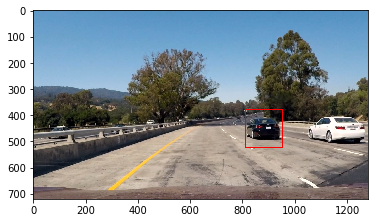

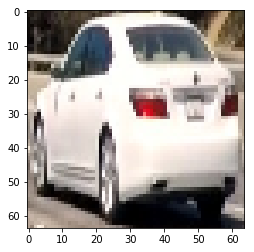

In [43]:
L = 144
S = 64
image = mpimg.imread('test_images/test1.jpg')
img = draw_boxes(image, [((810,380),(810+L,380+L))], color=(255, 0, 0), thick=2)
fig = plt.figure()
plt.imshow(img)

#L = 106
#S = 64
#image = mpimg.imread('test_images/test3.jpg')
#img = draw_boxes(image, [((866,384),(866+L,384+L))], color=(255, 0, 0), thick=2)

#L = 64
#S = 64
#image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0002.png')

#ii = cv2.resize(image[810:810+L,380:380+L], (S, S))   
#ii = cv2.resize(image[408:496,812:946], (64, 64)) 
ii = cv2.resize(image[404:508,1048:1274], (64, 64)) 
fig = plt.figure()
plt.imshow(ii)

image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
print('image_features', image_features)
p = model.predict(image_features)
print ('p', p)

image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0002.png')
image_features = extract_features([image])
image_features = X_scaler.transform(image_features)
print('image_features', image_features)


In [28]:
window_list = slide_window(image, xy_window=(L, L), xy_overlap=(0.9, 0.9)) 
print ('len(window_list)', len(window_list))
#print ('window_list', window_list)

len(window_list) 3444


In [29]:
i = 0
j = 0
for window in window_list:
    i = i + 1
#    if (window[1][0] >= 720) or (window[1][1] >= 1280):
#        continue
    ii = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (S, S))      
    image_features = extract_features([ii])
    image_features = X_scaler.transform(image_features)
#    fig = plt.figure()
#    plt.imshow(ii)

    p = model.predict(image_features)
#    print (p)
    if p[0] == 1:
        print (window)
    j = j + 1
print ('end', i, j)

end 3444 3444


In [30]:
make_video = False
if make_video:
    white_output = 'output'  + os.sep + 'project_video.mp4'
    clip = VideoFileClip("project_video.mp4")
    white_clip = clip.fl_image(process_image) 
    %time white_clip.write_videofile(white_output, audio=False)